## Install Library

In [ ]:
!pip install seaborn
!pip install neattext
!pip install tensorflow

## Import Library

In [73]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

## Cleaning Dataset

In [77]:
# URL of the dataset
dataset = 'https://raw.githubusercontent.com/Moodify-Project/Machine-Learning/main/Dataset/emotions_new.csv'
# load Dataset
df = pd.read_csv(dataset)

In [78]:
# Changing column name
df.rename(columns={'label': 'Emotion'}, inplace=True)
# Changing label name
df['Emotion'] = df['Emotion'].replace({0: 'sadness', 1: 'happiness', 2: 'anger', 3: 'worry', 4: 'enthusiasm'})
df.head()

,text,Emotion
0,i just feel really helpless and heavy hearted,worry
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,worry
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,worry


In [79]:
print(df['Emotion'].value_counts())

Emotion
happiness     146276
sadness       126352
anger          57427
worry          56171
enthusiasm     15731
Name: count, dtype: int64


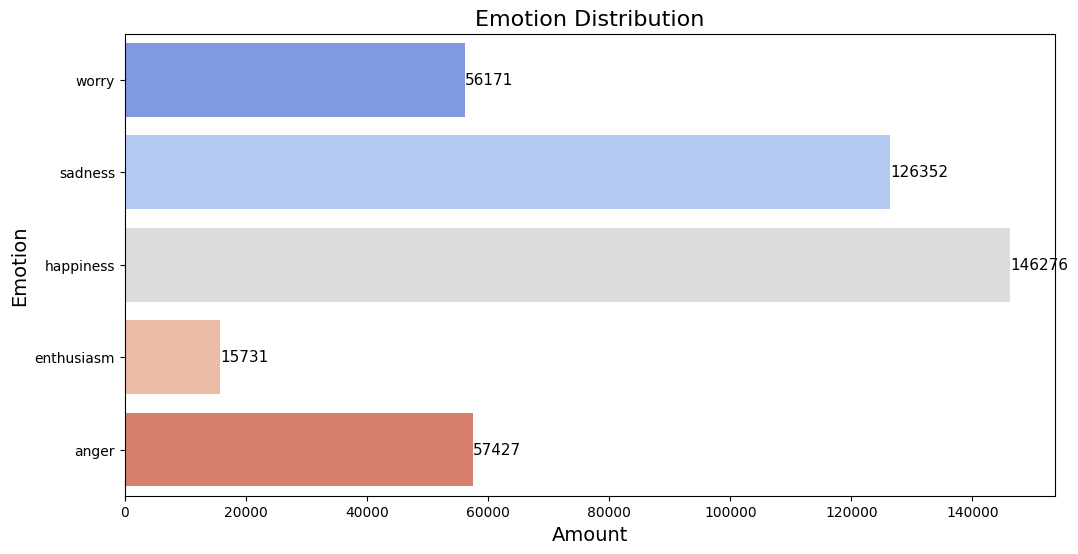

In [80]:
plt.figure(figsize=(12, 6))
palette = sns.color_palette("coolwarm", len(df["Emotion"].unique()))
ax = sns.countplot(y=df["Emotion"], hue=df["Emotion"], palette=palette, legend=False)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width() + 1, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=11, color='black')

plt.title("Emotion Distribution", fontsize=16)
plt.xlabel("Amount", fontsize=14)
plt.ylabel("Emotion", fontsize=14)
plt.show()

### Downsampling Dataset

In [81]:
# The lowest sampling size (enthusiasm)
min_sample_size = 15731

# Downsampling for each class
happiness_downsampled = resample(df[df['Emotion'] == 'happiness'],
                                  replace=False,
                                  n_samples=min_sample_size,
                                  random_state=42)

sadness_downsampled = resample(df[df['Emotion'] == 'sadness'],
                                replace=False,
                                n_samples=min_sample_size,
                                random_state=42)

worry_downsampled = resample(df[df['Emotion'] == 'worry'],
                              replace=False,
                              n_samples=min_sample_size,
                              random_state=42)

anger_downsampled = resample(df[df['Emotion'] == 'anger'],
                              replace=False,
                              n_samples=min_sample_size,
                              random_state=42)

enthusiasm_downsampled = df[df['Emotion'] == 'enthusiasm']

# Recombine
df_balanced = pd.concat([
    happiness_downsampled,
    sadness_downsampled,
    worry_downsampled,
    anger_downsampled,
    enthusiasm_downsampled
])

# Check the new distribution
print(df_balanced['Emotion'].value_counts())

Emotion
happiness     15731
sadness       15731
worry         15731
anger         15731
enthusiasm    15731
Name: count, dtype: int64


<ipython-input-89-5862a4038c2a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='Emotion', palette='viridis')


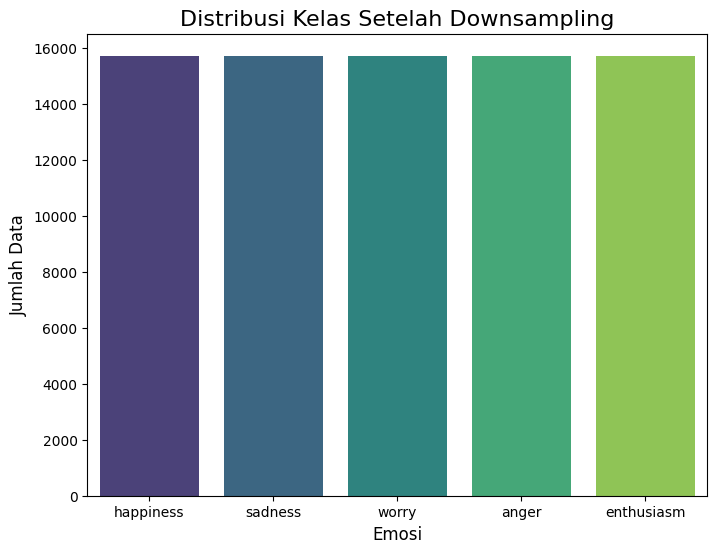

In [89]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_balanced, x='Emotion', palette='viridis')

plt.title('Distribusi Kelas Setelah Downsampling', fontsize=16)
plt.xlabel('Emosi', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)

plt.show()

## Data Preprocessing

In [ ]:
dir(nfx)

In [86]:
# Delete rows with empty values or non-string values.
df_balanced = df_balanced.dropna(subset=['text'])
df_balanced = df_balanced[df_balanced['text'].apply(lambda x: isinstance(x, str))]

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # lowercase
    text = nfx.remove_urls(text) # remove url
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) # remove hashtags
    text = re.sub(r'[^a-z\s]', ' ', text) # Remove non-alphabetic characters
    text = re.sub(r'\n', ' ', text) # Remove newlines
    text = nfx.remove_numbers(text) # remove number
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespaces
    text = nfx.remove_stopwords(text) # Delete stopwords
    text = ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])# Lemmatization
    return text

# Apply text cleaning to the 'text' column.
df_balanced['Clean_text'] = df_balanced['text'].apply(clean_text)

df_balanced[['text', 'Clean_text']]


,text,Clean_text
40200,i feel anything but fearless these days,feel fearless day
56523,i believe that everyone is made unique even th...,believe unique want feel accepted try blend cr...
231630,i say i feel jolly good to all around me but s...,feel jolly good sense exactly jolly jolly good
261578,i can feel the energy uplift and i can rest as...,feel energy uplift rest assured hit day
94792,i am not feeling especially festive or celebra...,feeling especially festive celebratory lately
...,...,...
401915,@ascrivner come over to my place for a cup of tea,come place cup tea
401918,CAN'T SLEEP TONIGHT . Oh see ya! Bye,sleep tonight oh ya bye
401932,@sierrabardot whaatttaatttt! she is a good coo...,whaatttaatttt good cook creative silly sierra
401937,BEEN TOWN WITH THE MOTHER NICE &amp; SUNNNY,town mother nice amp sunnny


### Save clean dataset

In [90]:
# Save the cleaned DataFrame to a CSV file
df_balanced[['Emotion', 'Clean_text']].to_csv('clean_dataset.csv', index=False)

## Exploratory Data Analysis (EDA)

In [91]:
# URL of the dataset
cleandataset = 'https://raw.githubusercontent.com/Moodify-Project/Machine-Learning/main/Dataset/clean_dataset.csv'
# load Dataset
df_emotion = pd.read_csv(cleandataset)

In [92]:
# Display the first few rows of the dataset
print(df_emotion.head())
print()

# Display basic information about the dataset
print(df_emotion.info())
print()

# Summary statistics
print(df_emotion.describe())
print()

# Check for missing values
print(df_emotion.isnull().sum())

     Emotion                                         Clean_text
0  happiness                                  feel fearless day
1  happiness  believe unique want feel accepted try blend cr...
2  happiness     feel jolly good sense exactly jolly jolly good
3  happiness            feel energy uplift rest assured hit day
4  happiness      feeling especially festive celebratory lately

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78655 entries, 0 to 78654
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Emotion     78655 non-null  object
 1   Clean_text  78633 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None

          Emotion  Clean_text
count       78655       78633
unique          5       74537
top     happiness  feel weird
freq        15731          52

Emotion        0
Clean_text    22
dtype: int64


In [93]:
# Removing rows that contain missing values:
df_emotion.dropna(subset=['Emotion', 'Clean_text'], inplace=True)

print(df_emotion.isnull().sum())

Emotion       0
Clean_text    0
dtype: int64


### Keyword Extraction

In [94]:
from collections import Counter

def extract_keywords(text,num=50):
    tokens = [ tok for tok in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

emotion_list = df_emotion['Emotion'].unique().tolist()

In [95]:
#Sadness
sadness_list = df_emotion[df_emotion['Emotion'] == 'sadness']['Clean_text'].dropna().tolist()
sadness_docx = ' '.join(sadness_list)

#Enthusiasm
enthusiasm_list = df_emotion[df_emotion['Emotion'] == 'enthusiasm']['Clean_text'].tolist()
enthusiasm_docx = ' '.join(enthusiasm_list)

#Worry
worry_list = df_emotion[df_emotion['Emotion'] == 'worry']['Clean_text'].tolist()
worry_docx = ' '.join(worry_list)

#Happiness
happiness_list = df_emotion[df_emotion['Emotion'] == 'happiness']['Clean_text'].tolist()
happiness_docx = ' '.join(happiness_list)

#Anger
anger_list = df_emotion[df_emotion['Emotion'] == 'anger']['Clean_text'].tolist()
anger_docx = ' '.join(anger_list)

In [96]:
# Extract Keyword
keyword_sadness = extract_keywords(sadness_docx)
keyword_enthusiasm = extract_keywords(enthusiasm_docx)
keyword_worry = extract_keywords(worry_docx)
keyword_happiness = extract_keywords(happiness_docx)
keyword_anger = extract_keywords(anger_docx)

In [97]:
def plot_most_common_words(mydict, emotion_name):
    df_01 = pd.DataFrame(mydict.items(), columns=['token', 'count'])
    df_01_sorted = df_01.sort_values('count', ascending=True).tail(15)

    plt.figure(figsize=(10, 6))

    plt.barh(df_01_sorted['token'], df_01_sorted['count'])
    plt.title(f"Top 15 Words for {emotion_name}", fontsize=15)
    plt.xlabel('Frekuensi', fontsize=12)
    plt.ylabel('Token', fontsize=12)

    for i, v in enumerate(df_01_sorted['count']):
        plt.text(v, i, f' {v}', va='center')

    plt.tight_layout()
    plt.show()

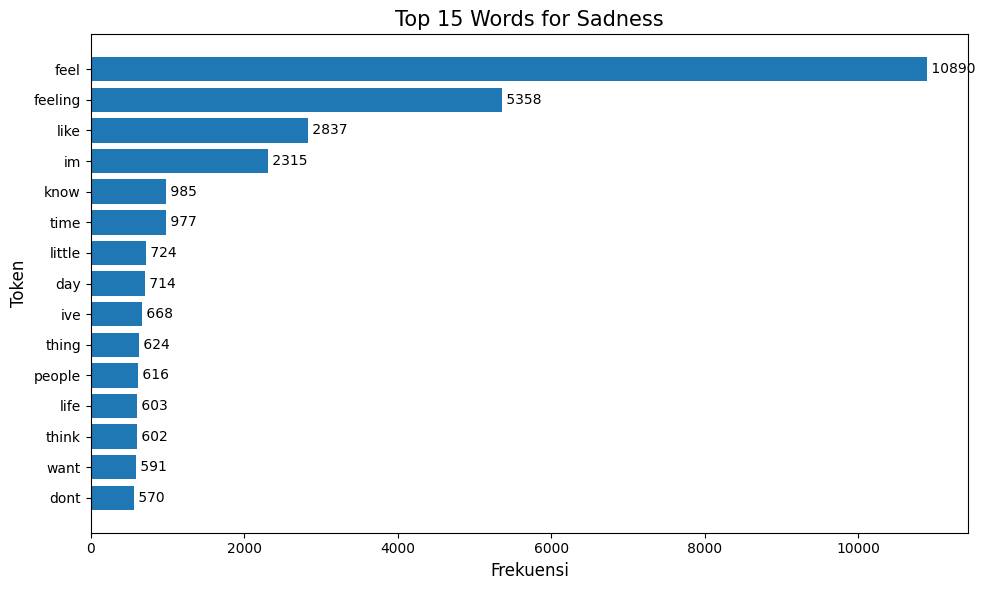

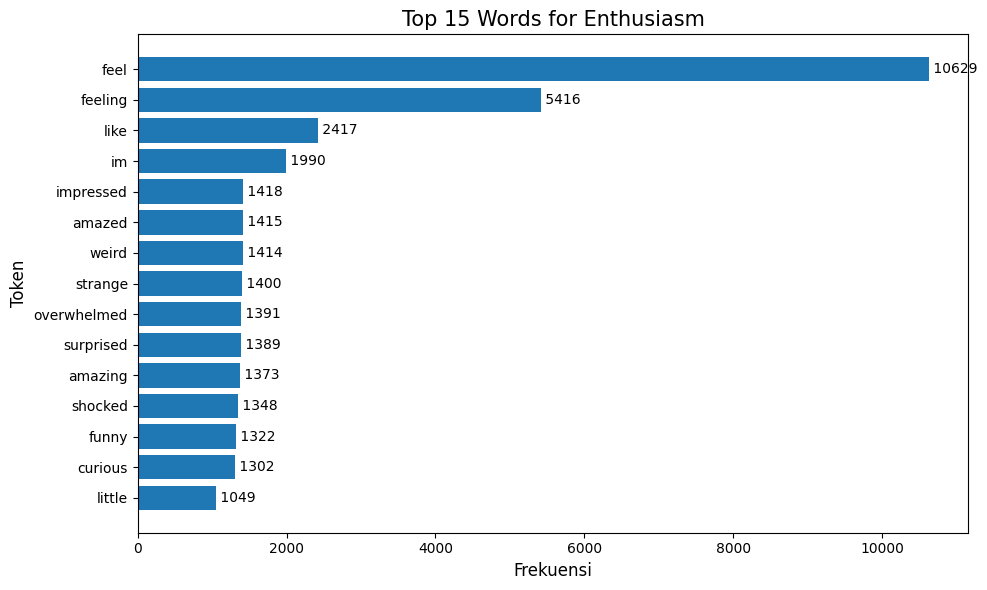

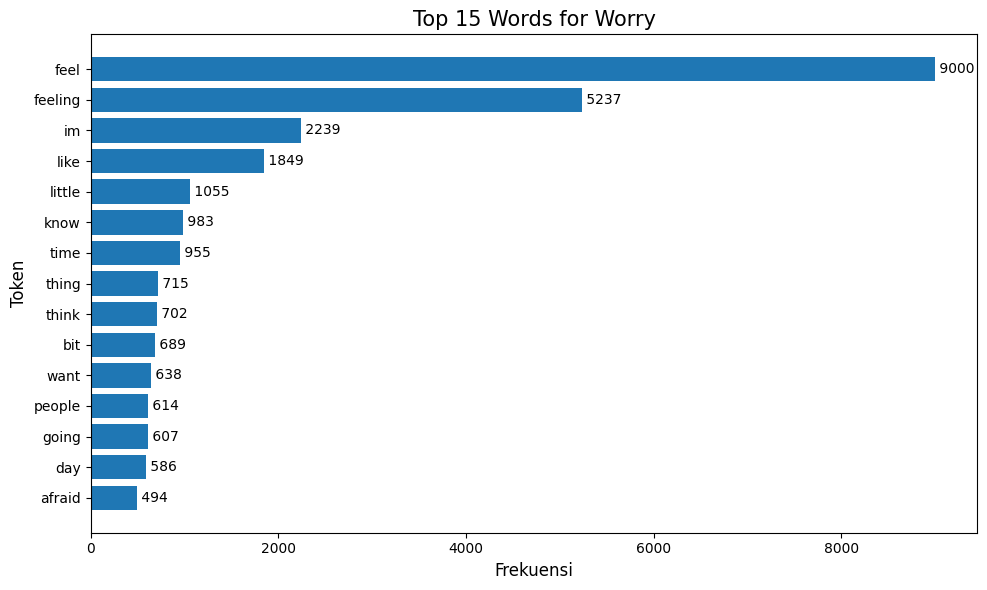

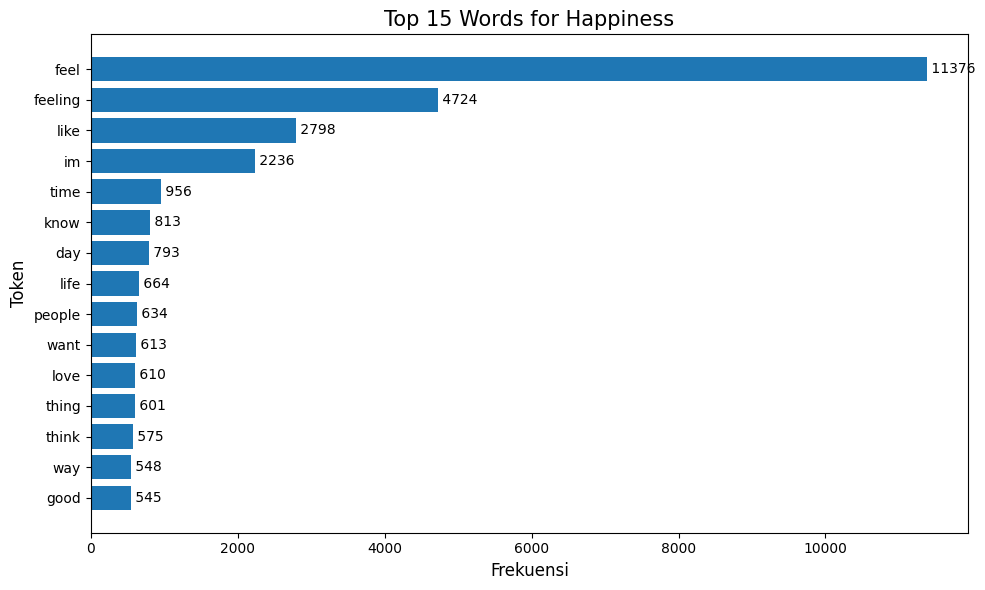

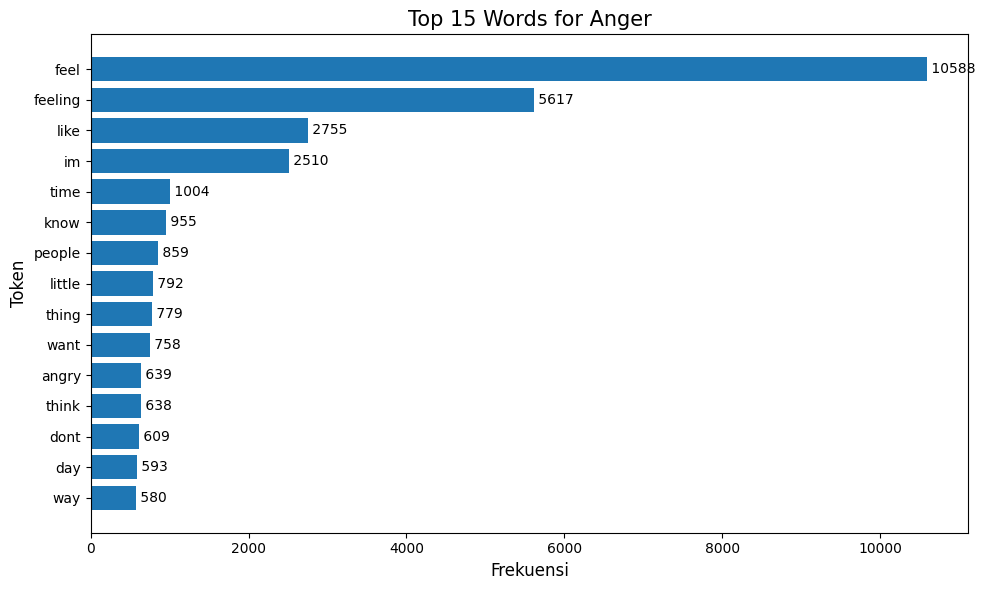

In [98]:
keywords = [
    ("Sadness", keyword_sadness),
    ("Enthusiasm", keyword_enthusiasm),
    ("Worry", keyword_worry),
    ("Happiness", keyword_happiness),
    ("Anger", keyword_anger)
]

for label, data in keywords:
    plot_most_common_words(data, label)

In [99]:
# Word Cloud
from wordcloud import WordCloud
def plot_wordcloud(docx):
    mywordcloud = WordCloud(width=800, height=400, background_color='white').generate(docx)
    plt.figure(figsize=(10,8))
    plt.imshow(mywordcloud,interpolation='bilinear')
    plt.title('Word Cloud of All Emotion')
    plt.axis('off')
    plt.show()

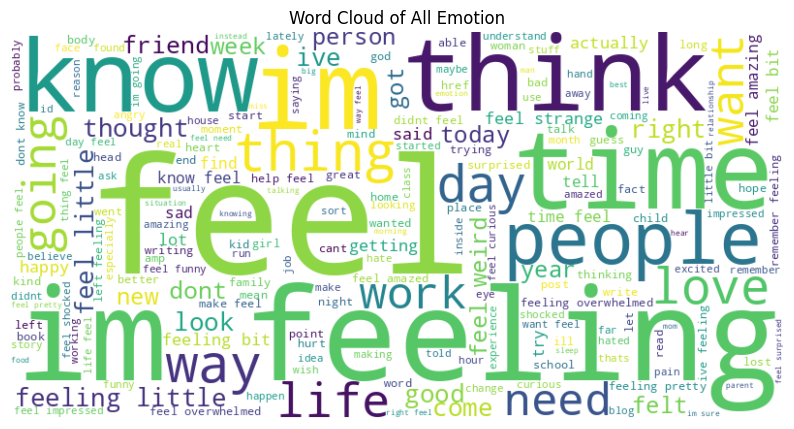

In [100]:
combined_docx = sadness_docx + " " + enthusiasm_docx + " " + worry_docx + " " + happiness_docx + " " + anger_docx + " "
plot_wordcloud(combined_docx)

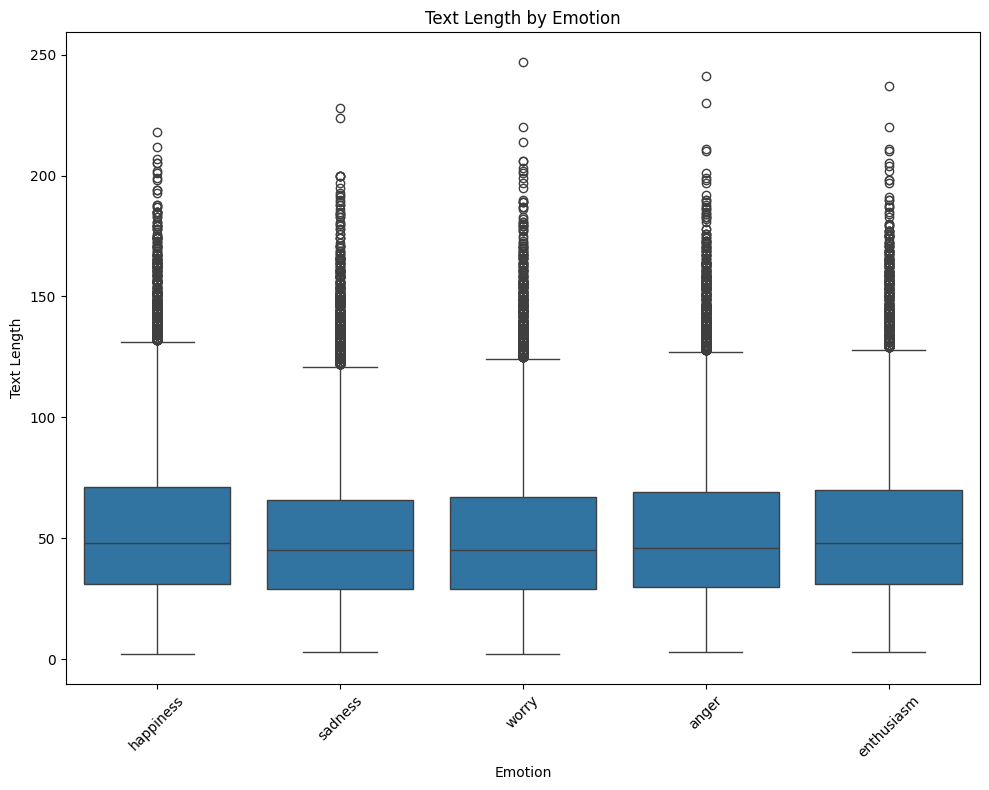

In [101]:
# Calculate the length of each text
df_emotion['text_length'] = df_emotion['Clean_text'].apply(len)

# Plot text length distribution by Emotion
plt.figure(figsize=(10, 8))
sns.boxplot(x='Emotion', y='text_length', data=df_emotion)
plt.title('Text Length by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Text Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Split Data

In [102]:
X = df_emotion['Clean_text']
y = df_emotion['Emotion']

# Separate data into training (80%) and temporary (20%).
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42)

print(f"Train shape: {X_train.shape}, Temporary shape: {X_temp.shape}")

Train shape: (62906,), Temporary shape: (15727,)


In [103]:
# Separate the temporary data into validation (50%) and test (50%).
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42)
print(f"Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Validation shape: (7863,), Test shape: (7864,)


In [104]:
print("Example data in X_train:")
print(X_train.head())

print("\nExample data in X_test:")
print(X_test.head())

print("\nExample data in X_val:")
print(X_val.head())

Example data in X_train:
56419    feel selfish listen need feel selfish thing de...
54       desperately want pregnant carry term enjoy fee...
24866       angry feel relationship feel like damaged good
42932                              feel inhibited spilling
25666                             started feel discouraged
Name: Clean_text, dtype: object

Example data in X_test:
23356    experienced usual angst fear turmoil western k...
39913                            feel like distraught lost
45957                           feel bit pressured rd book
73998    cant help feel bit dazed ending day morning ha...
48741                       feel wronged href http kikjkde
Name: Clean_text, dtype: object

Example data in X_val:
28180    drop supply contact lens switch im feeling esp...
9215                           feel lucky lot close friend
782             feel like got kiddos time sweet face photo
40682    feel threatened political economic system view...
23882    im happy pregnancy support 

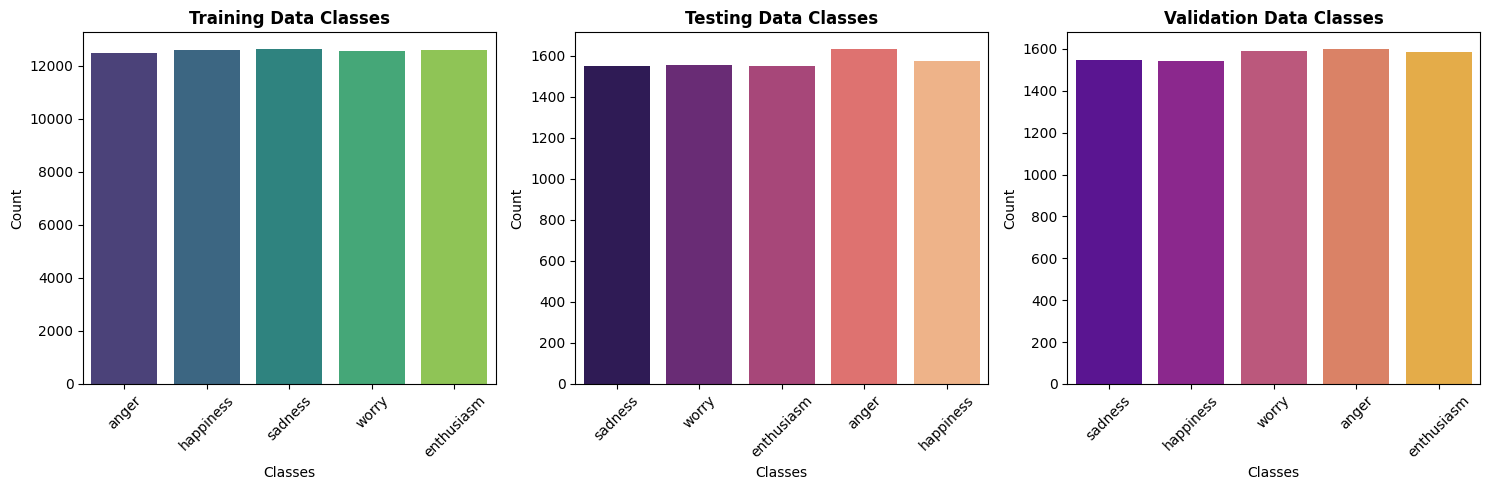

In [105]:
# Visualize classes counts
plt.figure(figsize=(15, 5))
# Subplot for training dataset
plt.subplot(131)
sns.countplot(x=y_train, palette='viridis', hue=y_train, legend=False)
plt.title("Training Data Classes", fontweight='bold')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Subplot for testing dataset
plt.subplot(132)
sns.countplot(x=y_test, palette='magma', hue=y_test, legend=False)
plt.title("Testing Data Classes", fontweight='bold')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Subplot for validation dataset
plt.subplot(133)
sns.countplot(x=y_val, palette='plasma', hue=y_val, legend=False)
plt.title("Validation Data Classes", fontweight='bold')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Label Encoding

In [106]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [107]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [108]:
y_train

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

## Tokenization

In [109]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

print(tokenizer.word_index)

In [111]:
X_datasets = [X_train, X_test, X_val]
sequences = [tokenizer.texts_to_sequences(data) for data in X_datasets]

sequences_train, sequences_test, sequences_val = sequences

In [112]:
for idx, (text, sequence) in enumerate(zip(X_train.iloc[:1], sequences_train[:1])):
    print(f"Original Text: {text}\nTokenized Sequence: {sequence}\n")

Original Text: feel selfish listen need feel selfish thing deserve listen need lost art listening need pile feel guilty listening need tapping come
Tokenized Sequence: [1, 170, 550, 19, 1, 170, 8, 1059, 550, 19, 114, 741, 610, 19, 1909, 1, 304, 610, 19, 6744, 44]



In [113]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [114]:
X_train, X_test, X_val = [pad_sequences(seq, maxlen=256, truncating='pre')
                           for seq in (sequences_train, sequences_test, sequences_val)]
vocab_size = len(tokenizer.index_word) + 1
print(f"Vocabulary size: {vocab_size} words")

Vocabulary size: 29131 words


## LSTM Model

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [144]:
def create_model(vocab_size):
    # Define model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Embedding(vocab_size, 128, input_length=X_train.shape[1]),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(128, kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(5),
        tf.keras.layers.Activation('softmax')
    ])

    adam = Adam(learning_rate=0.001)
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
	  )

    return model

In [145]:
# Create and print the model summary
model = create_model(vocab_size)
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 256, 128)            │       3,728,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             645 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,860,997 (14.73 MB)

 Trainable params: 3,860,997 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
# Early stopping
earlyStop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True)

In [146]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size = 128,
                    epochs=20,
                    callbacks=[earlyStop])

Epoch 1/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step - accuracy: 0.4355 - loss: 1.7469 - val_accuracy: 0.8871 - val_loss: 0.4300
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 138s 205ms/step - accuracy: 0.9058 - loss: 0.3804 - val_accuracy: 0.8989 - val_loss: 0.3614
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 141s 203ms/step - accuracy: 0.9212 - loss: 0.2891 - val_accuracy: 0.8999 - val_loss: 0.3280


### Evaluate Model

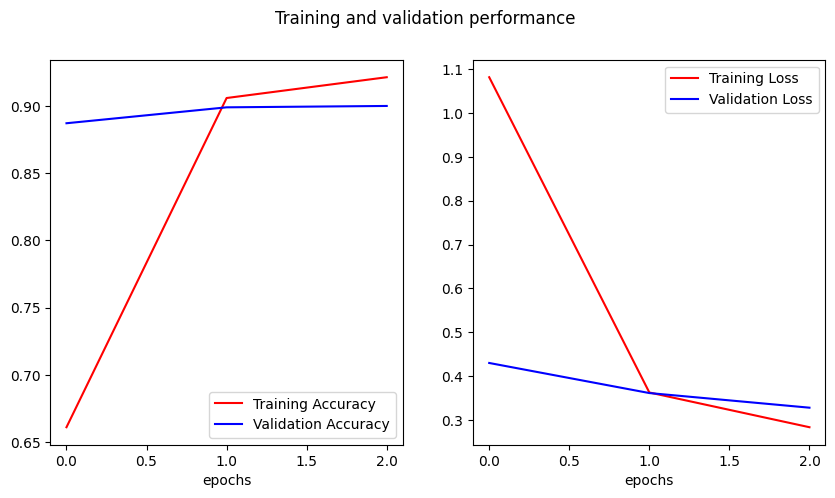

In [147]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

**Confusion matrix**

246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step


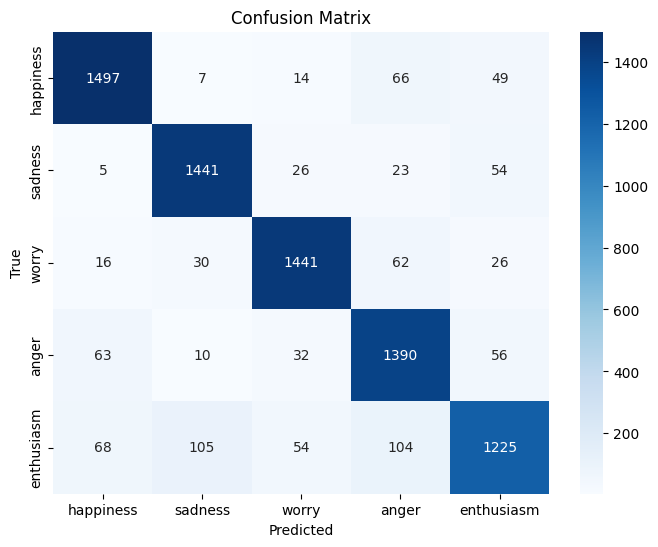

In [148]:
from sklearn.metrics import confusion_matrix

# Model predictions on test data
y_pred = model.predict(X_test)

# Converting probabilities into class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['happiness', 'sadness', 'worry', 'anger', 'enthusiasm'], yticklabels=['happiness', 'sadness', 'worry', 'anger', 'enthusiasm'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [149]:
from sklearn import metrics

# classification report
print(metrics.classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1633
           1       0.90      0.93      0.92      1549
           2       0.92      0.91      0.92      1575
           3       0.84      0.90      0.87      1551
           4       0.87      0.79      0.83      1556

    accuracy                           0.89      7864
   macro avg       0.89      0.89      0.89      7864
weighted avg       0.89      0.89      0.89      7864



## BiLSTM Model

In [160]:
def create_bimodel(vocab_size):
    # Define model
    bimodel = tf.keras.Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Embedding(vocab_size, 128, input_length=X_train.shape[1]),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True, recurrent_dropout=0.2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(LSTM(32)),
        tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=l2(0.01))
    ])

    adam = Adam(learning_rate=0.001)
    # Compile model
    bimodel.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
	  )

    return bimodel

In [161]:
# Create and print the model summary
bimodel = create_bimodel(vocab_size)
bimodel.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 256, 128)            │       3,728,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_6                  │ (None, 256, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 256, 120)            │          90,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256, 120)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 64)                  │          39,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,858,981 (14.72 MB)

 Trainable params: 3,858,981 (14.72 MB)

 Non-trainable params: 0 (0.00 B)

In [162]:
# Train the model
bihistory = bimodel.fit(X_train,
                      y_train,
                      validation_data=(X_test, y_test),
                      verbose=1,
                      batch_size=256,
                      epochs=20,
                      callbacks=[earlyStop])

Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.4700 - loss: 1.2897 - val_accuracy: 0.8892 - val_loss: 0.4081
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.9088 - loss: 0.3391 - val_accuracy: 0.9022 - val_loss: 0.3139
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.9367 - loss: 0.2337 - val_accuracy: 0.9068 - val_loss: 0.3011


### Evaluate Model

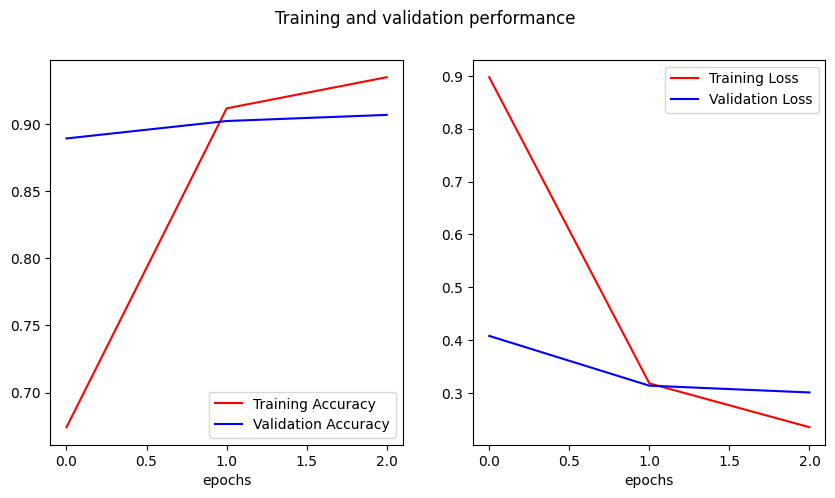

In [163]:
# Get training and validation accuracies
acc = bihistory.history['accuracy']
val_acc = bihistory.history['val_accuracy']
loss = bihistory.history['loss']
val_loss = bihistory.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

**Confusion matrix**

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 461ms/step


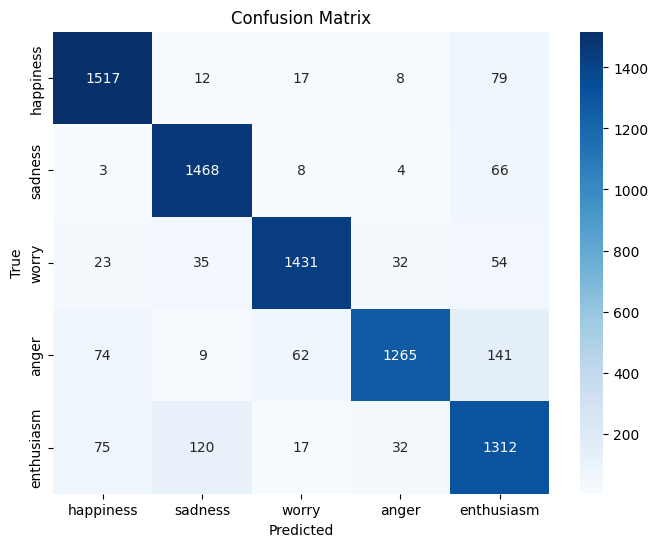

In [164]:
# Model predictions on test data
y_bipred = bimodel.predict(X_test, batch_size=256)

y_bipred_classes = np.argmax(y_bipred, axis=1)
y_bitrue_classes = np.argmax(y_test, axis=1)

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_bitrue_classes, y_bipred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['happiness', 'sadness', 'worry', 'anger', 'enthusiasm'], yticklabels=['happiness', 'sadness', 'worry', 'anger', 'enthusiasm'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [165]:
# classification report
print(metrics.classification_report(y_bitrue_classes, y_bipred_classes))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1633
           1       0.89      0.95      0.92      1549
           2       0.93      0.91      0.92      1575
           3       0.94      0.82      0.87      1551
           4       0.79      0.84      0.82      1556

    accuracy                           0.89      7864
   macro avg       0.89      0.89      0.89      7864
weighted avg       0.89      0.89      0.89      7864



## Save Model

In [176]:
from google.colab import files
import shutil

# Save model
#bimodel.save('model.keras')
#files.download('/content/model.keras')

# Save folder
#bimodel.export('model')
shutil.make_archive('/content/model', 'zip', '/content', 'model')
files.download('/content/model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Classify custom sample and predictions

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.keras')

def predict(sentence, model):
    # Preprocess the sentence
    sentence = clean_text(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')

    # Prediction of results and probabilities
    predictions = model.predict(sentence)[0]
    proba = np.array(predictions)
    labels = le.classes_

    # Displaying probability
    for i, label in enumerate(labels):
        print(f"{label}: {proba[i]*100:.2f}%")

    # Displaying the highest probability
    result = labels[np.argmax(proba)]
    max_proba = np.max(proba)
    print(f"\nEmotion Prediction: {result} with probability {max_proba*100:.2f}%\n\n")


In [174]:
# Enter the text you want to predict
sample_text = "Lately, I’ve been feeling a sense of worry that seems to linger throughout my days. It’s as if there’s a constant unease in the back of my mind, making even simple tasks feel overwhelming. I find myself overthinking every decision, fearing that I might make the wrong choice or miss an important detail. It’s exhausting, and no matter how hard I try to focus on the present moment, my mind keeps drifting to potential problems that haven’t even happened yet. The uncertainty of the future only adds to the weight of my worries, leaving me questioning whether I am truly doing enough to prepare for what’s ahead."
predict(sample_text, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
anger: 10.39%
enthusiasm: 3.24%
happiness: 4.38%
sadness: 18.46%
worry: 63.53%

Emotion Prediction: worry with probability 63.53%


